In [33]:
# import sql engine, pandas, numpy
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
!ls


README.md                         rover.com-analytics-project.ipynb
db1.sqlite3


In [3]:
# the sqlite database can be converted to use postgresql using pgloader
# First you must have postgresql installed
# Then create an empty db to load the database into
# In this instance, I created a 'rover' db
# I used postgresql to explore the data set, but use python via pscopg to visualize the query result

# !pgloader db1.sqlite3 postgresql:///rover

# EXERCISES


# I. Exploring the Database

In [5]:
conn = psycopg2.connect('dbname=rover')
cur = conn.cursor()

### 1. How many users have signed up?

In [26]:
query =  '''
SELECT 
    COUNT(*)
FROM
	people_person;
    '''
cur.execute(query)

df_1= pd.read_sql_query(query,conn)
df_1

,count
0,64393


### 2. How many users signed up prior to 2018-02-03 ?

In [25]:
query =  '''
SELECT 
    COUNT(*)
FROM
	people_person
WHERE date_joined < '2018-02-03'    
    ;
    '''
df_2 = pd.read_sql_query(query,conn)
df_2

,count
0,35826


### 3. What percentage of users have added pets?
#### One thing to note, when dealing with percentages, either cast the numerator to a decimal/numeric, or just make the percentage conversion by using 100.0 (a float) vs 100 (a integer) to keep the precision

In [51]:
query='''
SELECT
    ROUND(count(distinct owner_id)*100.0/(SELECT COUNT(*) FROM people_person),2) as percentage
FROM 
    pets_pet;
'''
df_3= pd.read_sql_query(query,conn)
df_3

# this number gives me the number of users that have registered pets
# now to get a count of the total users, I just divide this number by the total found
# in question 1

,percentage
0,80.43


In [38]:
soln = df_3['count'] / df_1['count']

soln[0].round(4) *100

80.43

### 4. Of those users, how many pets have they added on average?

In [42]:
query ='''
SELECT
    ROUND(avg(count),3) as average_added_pets
FROM
    (
    SELECT 
        COUNT(id) as count, owner_id
    FROM 
        pets_pet
    GROUP BY 
        owner_id) as counts;'''
df_4 = pd.read_sql_query(query,conn)
df_4

,average_added_pets
0,1.501


### 5. What percentage of pets play well with cats?

In [56]:
query = '''
SELECT
ROUND(count(CASE WHEN plays_cats THEN 1 END)*100::decimal/ (SELECT COUNT(*) FROM pets_pet),2) as percentage
FROM pets_pet;
'''
df_5= pd.read_sql_query(query,conn)
df_5

,percentage
0,24.85


 ## III. Recent Daily Booking Rate
 #### The snapshot of this database was taken on 2018-08-02 at midnight and only contains data reflecting events prior to that date. A junior analyst is investigating daily booking rate during the days prior to the snapshot and is concerned about an apparent downward trend. You are tasked with helping them out.
#### First, let's reproduce their results. They tell you that daily booking rate is defined to be the percentage of conversations created each day that eventually book.
#### 1. What is the daily booking rate for each of the 90 days prior to the snapshot? Is there a downward trend?
#### 2. Can you narrate a reason why this trend exists? Is there a reason to be concerned? Please provide additional data and evidence to justify your position.

### 1. What is the daily booking rate for each of the 90 days prior to the snapshot? Is there a downward trend?

In [85]:

# First, lets view the columns of the conversations_conversation table

query = '''
SELECT 
    DATE(added) as dated, ROUND(COUNT(booked_at)*100.0 / COUNT(*),2) as conversion_rate
FROM 
    conversations_conversation
GROUP BY 
    dated
ORDER BY
    dated ASC
LIMIT 90;
'''
df = pd.read_sql_query(query,conn)
df

#lets see the whole dataframe


,dated,conversion_rate
0,2016-08-10,50.00
1,2016-08-11,50.00
2,2016-08-12,0.00
3,2016-08-13,100.00
4,2016-08-14,25.00
...,...,...
85,2016-11-05,34.78
86,2016-11-06,50.00
87,2016-11-07,35.29
88,2016-11-08,55.56


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
dated              90 non-null object
conversion_rate    90 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


In [88]:
df.describe()

,conversion_rate
count,90.000000
mean,41.064222
std,19.961266
min,0.000000
25%,31.250000
50%,39.445000
75%,50.000000
max,100.000000


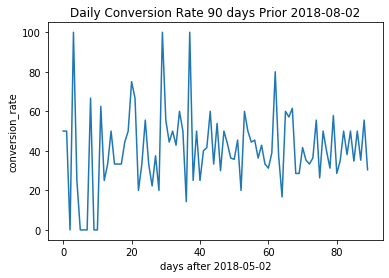

In [84]:
plt.plot(df['conversion_rate'])
plt.ylabel('conversion_rate')
plt.xlabel('days after 2018-05-02')
plt.title('Daily Conversion Rate 90 days Prior 2018-08-02')
plt.show();

#### 2. Can you narrate a reason why this trend exists? Is there a reason to be concerned? Please provide additional data and evidence to justify your position.

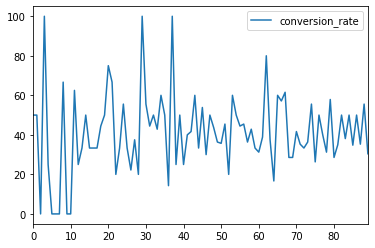

In [76]:
df.plot(y='conversion_rate',use_index=True,kind='line')

 Looking at the columns and table, to get the count of total conversations, we can use the start_date to indicate each and every conversation that takes place. A pet_owner can start conversations with many different providers, so we want to keep track of that.
 
To find the total of booked services, the simple method would be to just take the total number of 'booked_at' column divided by the total count of the table. But to be more specific, we can also account for when a booked_request is cancelled by also accounting for the 'cancelled_at' column.

In [ ]:
SELECT COUNT(*)

 ## IV. Analyzing Take Rate (IV)

 ## VI. Search Engine Marketing (VI).